In [3]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the downstream loss 
# figures
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "hi"
idx_1 = "002"
tag_sil_1 = "basev1"

# FERT LEVEL 2
fertLevel_2 = "low"
idx_2 = "002"
tag_sil_2 = "basev1"



In [4]:
# ---- READ IN DATA
# FERT LEVEL 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))

# FERT LEVEL 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))

In [5]:
# -----------------------------------------
# --- UPDATE FOR AWS:
# # read in files using this format
# import s3fs

# fs = s3fs.S3FileSystem()
# s3path = 's3://cplan/my/file.nc'
# with fs.open(s3path, mode='rb') as fn:
#     tx = xr.open_dataset(fn)
# -----------------------------------------

# Plot 1a: LowFert
changing breakeven line with different loss percentages

(0.8, 100)

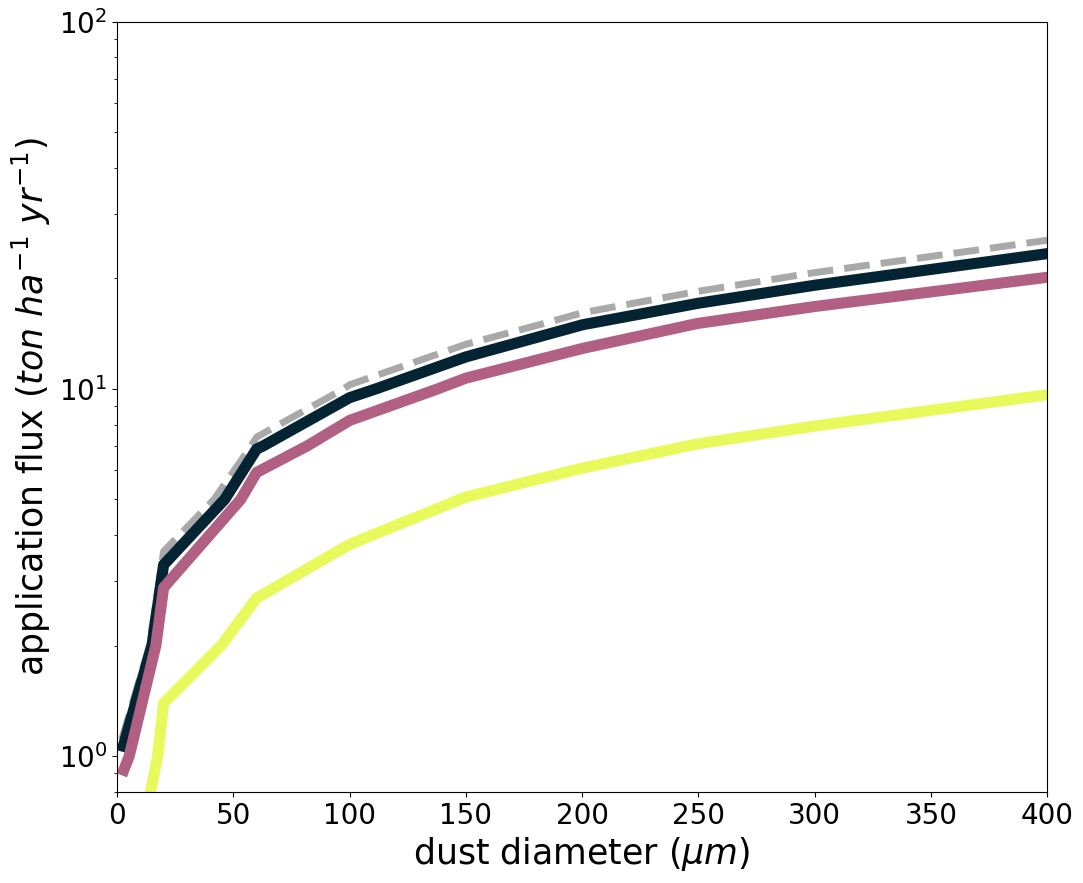

In [17]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percents = [0, 10, 20, 40]
cdr_calc = 'netR_noNeg'
logX = False
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[0], method='nearest')[cdr_var]
dsanom2_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[1], method='nearest')[cdr_var]
dsanom3_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[2], method='nearest')[cdr_var]
dsanom4_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[3], method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom3_p4 = dsanom3_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom4_p4 = dsanom4_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 400
ymin, ymax = (0.8 if logY else 0), 100 
# *****************************

# x and y arrays
# [emisslevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# # [fertlevel 2]
# x2 = dsanom2_p4['dustrad'].values
# y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values

# get colors for the colormap
colormap = cmo.thermal
cols = [colormap(i) for i in np.linspace(0,1,3)]

# --- SET UP PLOT
spec = GridSpec(ncols=1, nrows=1)
plt.figure(figsize=(12,10))

# --- fertlevel 1
ax = plt.subplot(spec[0])
# contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
#                         levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
# one line per loss fraction
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[0], colors='darkgray', linestyles='--', linewidths=5)
contour_line = plt.contour(x1*2,y1,dsanom2_p4.transpose(),levels=[0], colors=cols[0], linewidths=8)
contour_line = plt.contour(x1*2,y1,dsanom3_p4.transpose(),levels=[0], colors=cols[1], linewidths=8)
contour_line = plt.contour(x1*2,y1,dsanom4_p4.transpose(),levels=[0], colors=cols[2], linewidths=8)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


# Plot 1b: HiFert
changing breakeven line with different loss percentages

(0.8, 100)

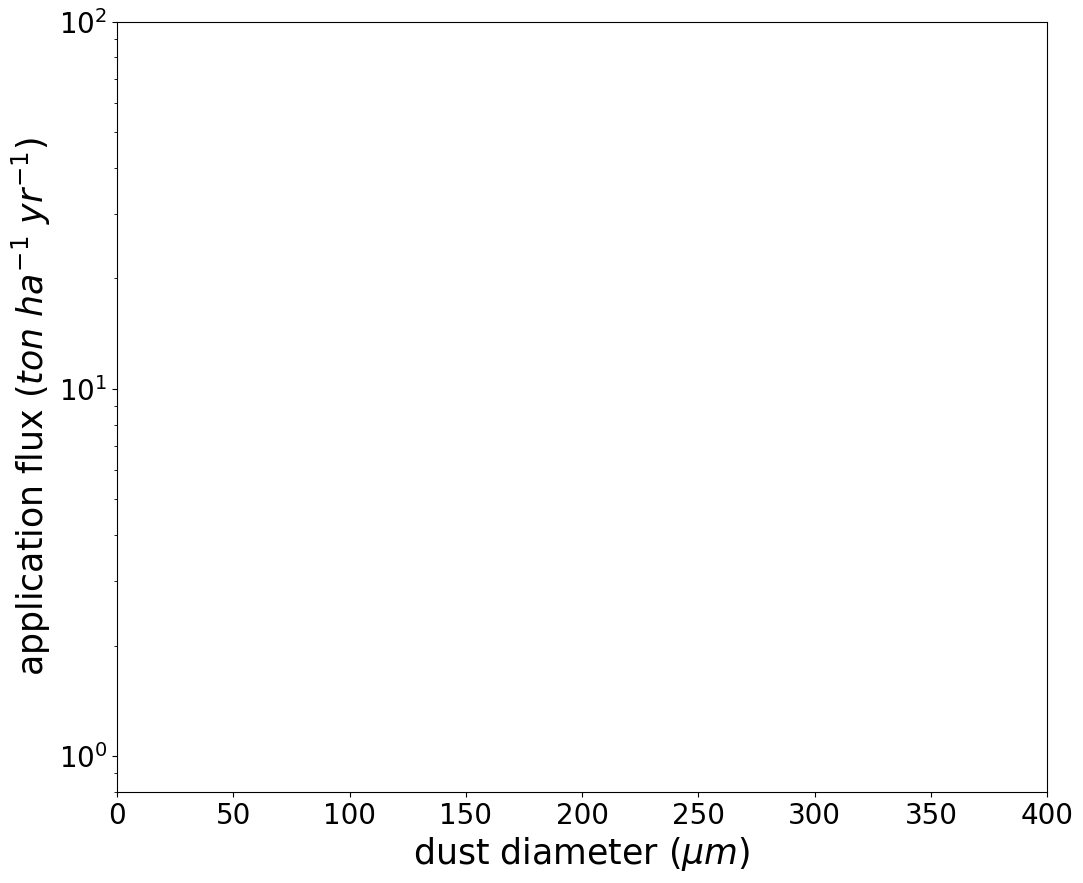

In [19]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percents = [0, 10, 20, 40]
cdr_calc = 'netR_noNeg'
logX = False
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[0], method='nearest')[cdr_var]
dsanom2_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[1], method='nearest')[cdr_var]
dsanom3_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[2], method='nearest')[cdr_var]
dsanom4_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percents[3], method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom3_p4 = dsanom3_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom4_p4 = dsanom4_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 400
ymin, ymax = (0.8 if logY else 0), 100 
# *****************************

# x and y arrays
# [emisslevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# # [fertlevel 2]
# x2 = dsanom2_p4['dustrad'].values
# y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values

# get colors for the colormap
colormap = cmo.thermal
cols = [colormap(i) for i in np.linspace(0,1,3)]

# --- SET UP PLOT
spec = GridSpec(ncols=1, nrows=1)
plt.figure(figsize=(12,10))

# --- fertlevel 1
ax = plt.subplot(spec[0])
# contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
#                         levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
# one line per loss fraction
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[-0.01], colors='darkgray', linestyles='--', linewidths=5)
contour_line = plt.contour(x1*2,y1,dsanom2_p4.transpose(),levels=[-0.01], colors=cols[0], linewidths=8)
contour_line = plt.contour(x1*2,y1,dsanom3_p4.transpose(),levels=[-0.01], colors=cols[1], linewidths=8)
contour_line = plt.contour(x1*2,y1,dsanom4_p4.transpose(),levels=[-0.01], colors=cols[2], linewidths=8)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


# Plot 2: 
Illustrate the effect of downstream loss for aglime and silicate

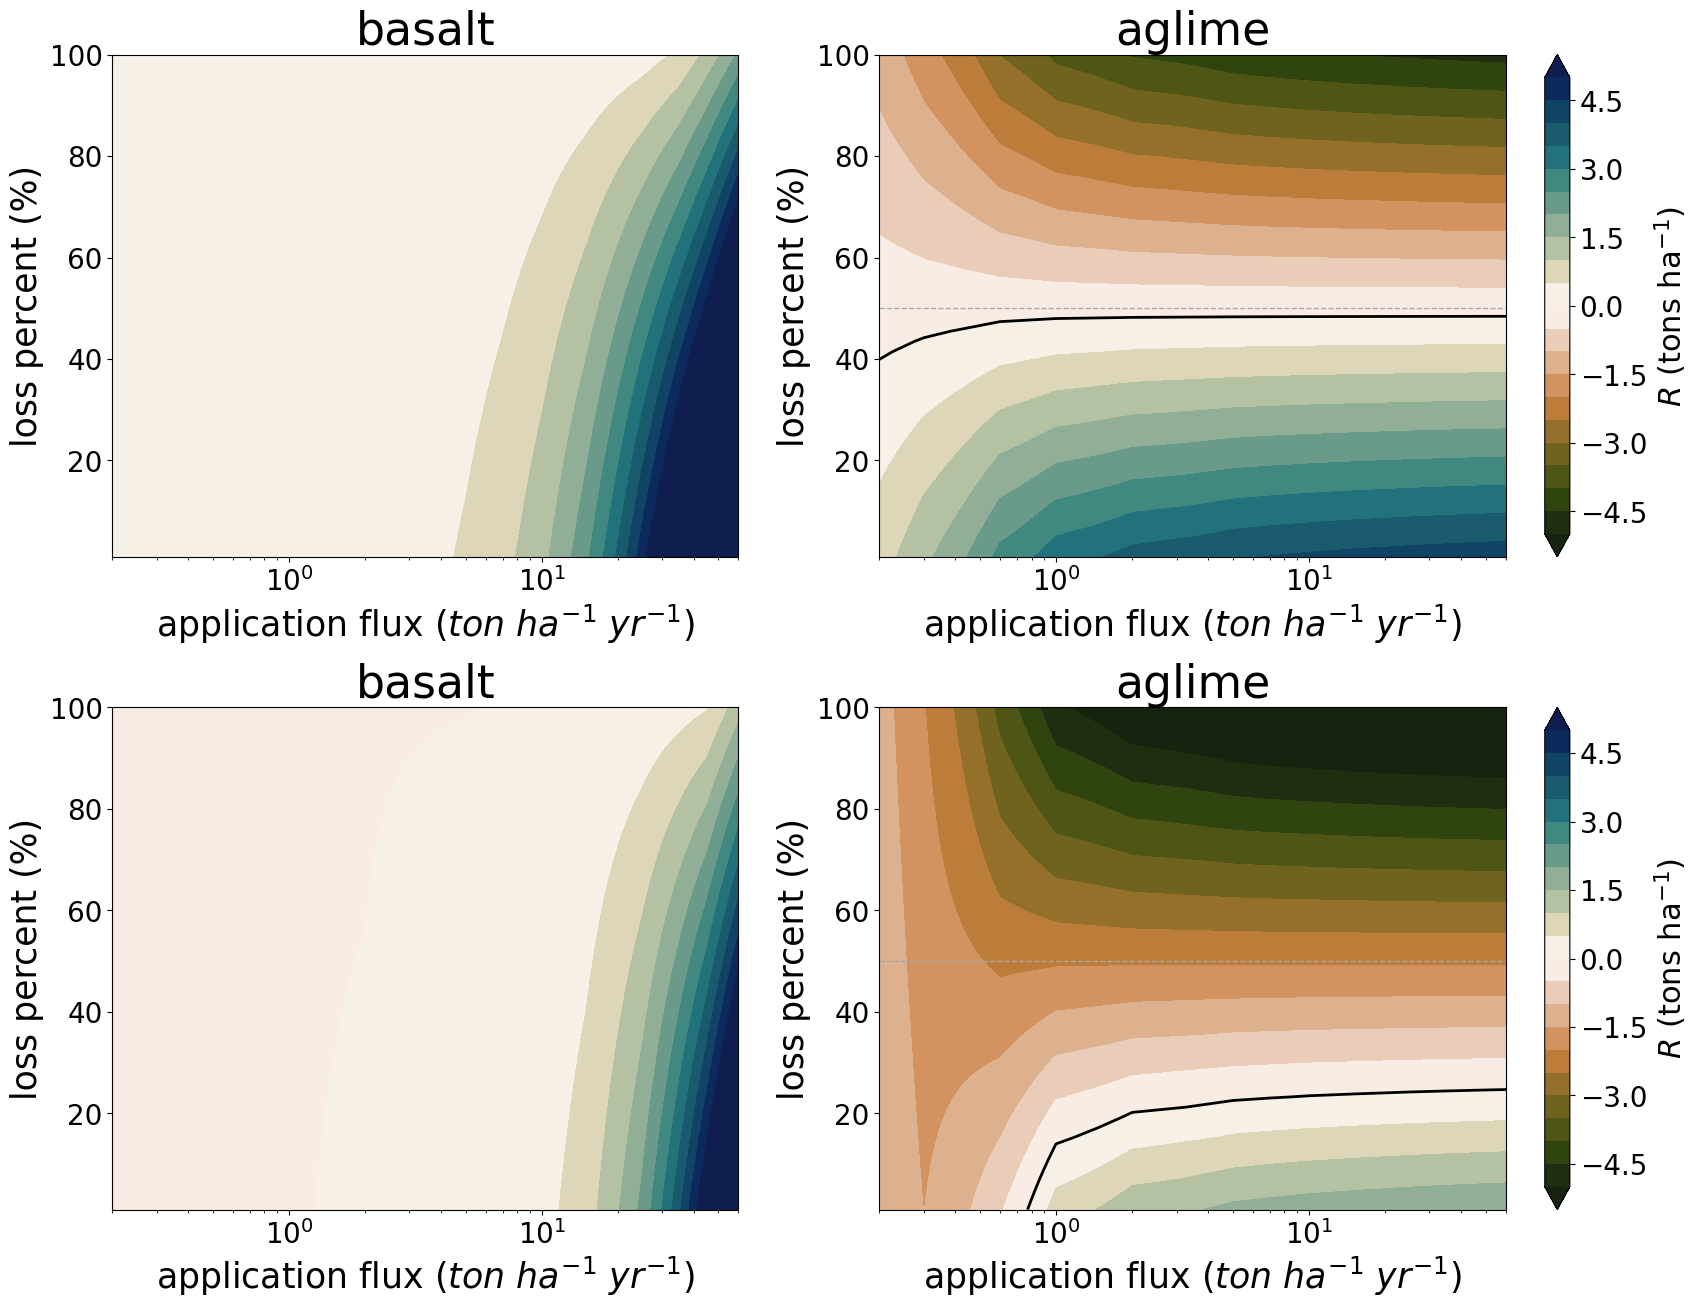

In [14]:
# --- PLOT --------------------
# set data conditions
cdr_var = 'cdr_dif'
rad = 100
fertlevel_show = 12   # [1 | 2 | 12]
logX = True

# pull out the data we want
dssil1_p3 = dssil1.sel(dustrad = rad, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(dustrad = rad, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(dustrad = rad, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(dustrad = rad, method='nearest')[cdr_var]

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.tarn
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (0.2 if logX else 0), 60
xmin, xmax = 0.2, 60
ymin, ymax = 0, 100
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrate_ton_ha_yr'].values
y1sil = dssil1_p3['loss_percent'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrate_ton_ha_yr'].values
y1cc = dscc1_p3['loss_percent'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrate_ton_ha_yr'].values
y2sil = dssil2_p3['loss_percent'].values
# [fertlevel 2, cc]
x2cc = dscc1_p3['dustrate_ton_ha_yr'].values
y2cc = dscc1_p3['loss_percent'].values

# update index based on which ferts to show
if fertlevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (fertlevel_show == 2) | (fertlevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("basalt", fontsize=fs_title)
    if logX:
        plt.xscale('log')
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    if logX:
        plt.xscale('log')
    plt.xlim(xmin, xmax)

if (fertlevel_show == 1) | (fertlevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.title("basalt", fontsize=fs_title)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    plt.xlim(xmin, xmax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
    contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    plt.xlabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.ylabel("loss percent (%)", fontsize=fs_ylab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    plt.title("aglime", fontsize=fs_title)
    cbar = plt.colorbar(contour)
    cbar.set_label(r"$R\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    plt.xlim(xmin, xmax)

# Plot 3: 
Contour plot of sil minus aglime

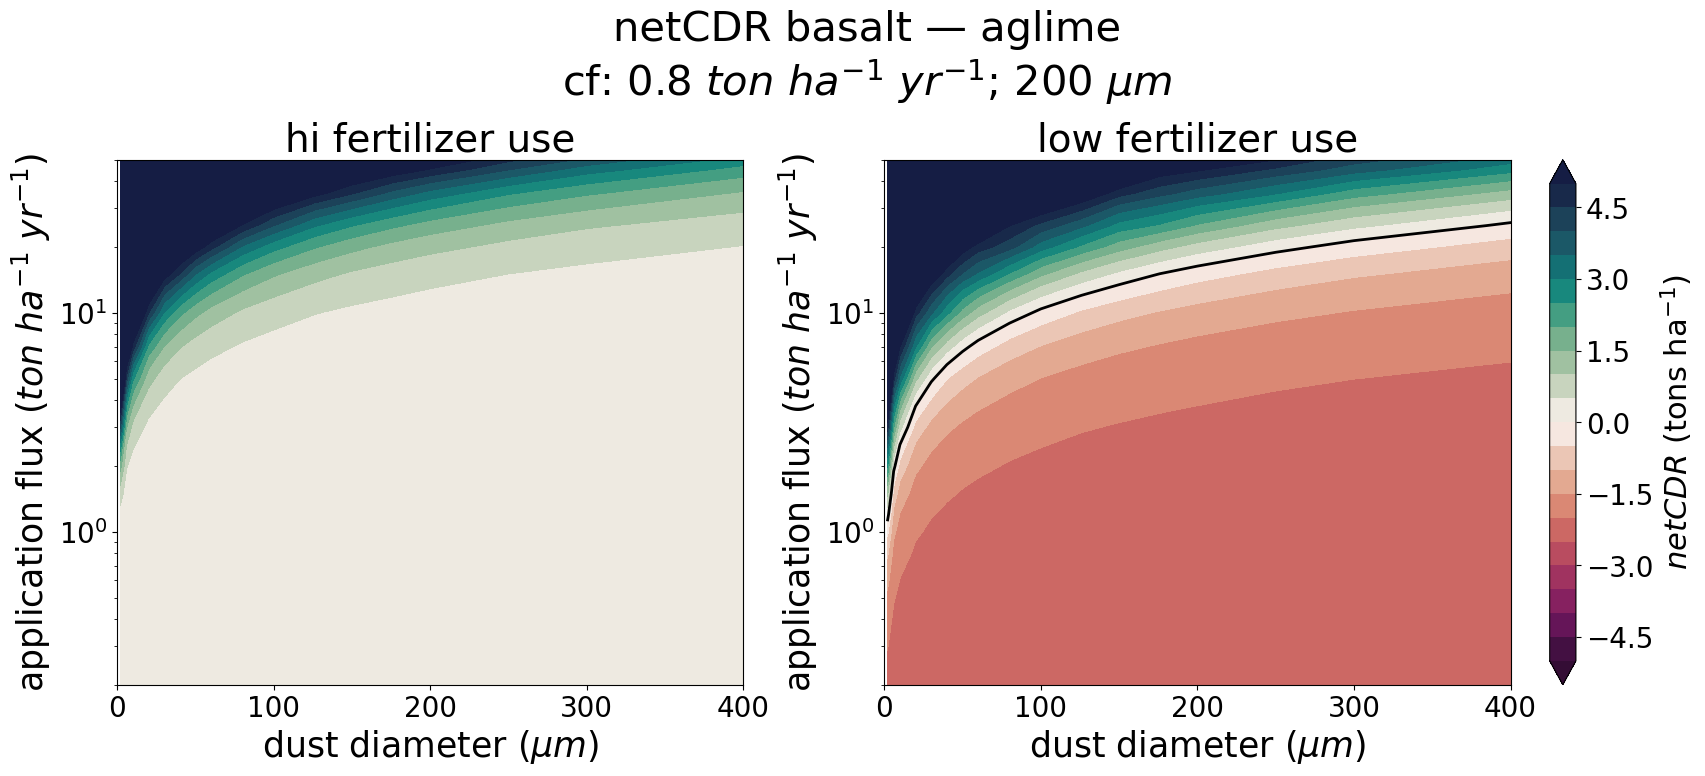

In [23]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_adv' # 'co2pot_adv_tonHa_camg' 
loss_percent = 10
cdr_calc = 'netR_noNeg'
logX = False
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom2_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 400
ymin, ymax = (0.2 if logY else 0), 50 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
x2 = dsanom2_p4['dustrad'].values
y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsanom2_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom2_p4.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


In [ ]:
# --------